In [2]:
import logging
import argparse
import pyabc
import numpy as np
import os
from contagion import Contagion
from contagion.config import _baseconfig
from dask.distributed import Client
from summary_stats import make_sum_stats
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import scipy

In [3]:
def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

In [4]:
data = np.loadtxt("cpp_model.csv", delimiter=",")
my_config = yaml.safe_load(open("benchmark_config.yaml"))
fields = ["is_recovered", "is_infectious", "is_latent"]
#data = {field: np.asarray(contagion.statistics[field]) for field in fields}
data = {"is_recovered": data[:, 1], "is_infectious": data[:, 0], "is_latent": data[:, 2]}

def model(parameters, variance_mode):
    this_config = dict(_baseconfig)
    this_config.update(my_config)
    this_config['population']['social circle pdf']["mean"] = parameters["soc circ mean"]        
    this_config['population']['social circle interactions pdf']["mean"] = parameters["soc circ mean"]        
    this_config['infection']["latency duration pdf"]['mean'] =  parameters["latency mean"]        
    this_config['infection']["infectious duration pdf"]['mean'] =  parameters["infectious dur mean"]        
    this_config['infection']["recovery time pdf"]['mean'] =  parameters["recovery dur mean"]        
    this_config['infection']["incubation duration pdf"]['mean'] =  parameters["incub dur mean"]        
    this_config['infection']["infection probability pdf"]['max_val'] =  parameters["inf prob max"]   
    this_config['infection']["incubation duration pdf"]['sd'] =  parameters["incub dur sd"] 
    

    if variance_mode == "mean":
        this_config['infection']["recovery time pdf"]['sd'] =  np.sqrt(parameters["recovery dur mean"])
        this_config['infection']["infectious duration pdf"]['sd'] =  np.sqrt(parameters["infectious dur mean"])
        this_config['infection']["latency duration pdf"]['sd'] =  np.sqrt(parameters["latency mean"])
        this_config['population']['social circle interactions pdf']["sd"] = np.sqrt(parameters["soc circ mean"])
        this_config['population']['social circle pdf']["sd"] = np.sqrt(parameters["soc circ mean"])

    elif variance_mode == "minimal":
        this_config['infection']["recovery time pdf"]['sd'] =  0.1
        this_config['infection']["infectious duration pdf"]['sd'] =  0.1
        this_config['infection']["latency duration pdf"]['sd'] =  0.1
        this_config['population']['social circle interactions pdf']["sd"] = 0.1
        this_config['population']['social circle pdf']["sd"] = 0.1 

    else:
        raise RuntimeError("Unknown variance mode: {}".format(args.variance_mode))

    this_config["population"]["re-use population"] = False
    contagion = Contagion(userconfig=this_config)
    contagion.sim()

    stats = contagion.statistics
    stats = pd.DataFrame(contagion.statistics)
    stats["is_recovered"] = stats["is_recovered"] + stats["is_recovering"]
    
    return stats, contagion.trace_infection

In [10]:
db_path = "sqlite:///" + os.path.join(os.environ["HOME"], "abc.db")
h_loaded = pyabc.History(db_path, 36)


df, w = h_loaded.get_distribution(m=0,)
par_medians = {col: weighted_quantile(df[col].values, [0.5], sample_weight=w ).item() for col in df.columns}
print(par_medians)
par_means = {col: np.average(df[col].values, weights=w) for col in df.columns}
print(par_means)

par_modes = {}
for field in df.columns:
    kde = scipy.stats.gaussian_kde(df[field].values, weights=w)
    
    maxval = scipy.optimize.minimize(lambda x: -kde(x), df[field].sample(1, weights=w).values[0])
    par_modes[field] = maxval.x[0]
print(par_modes)

{'incub dur mean': 7.125677344235247, 'incub dur sd': 9.796636662248032, 'inf prob max': 0.2530619980242555, 'infectious dur mean': 8.02159406102965, 'latency mean': 4.160816734015624, 'recovery dur mean': 1.5544061639568851, 'soc circ mean': 6.622421474617797}
{'incub dur mean': 7.1140943530931455, 'incub dur sd': 9.732652999435986, 'inf prob max': 0.250882328981498, 'infectious dur mean': 7.9746635858424675, 'latency mean': 4.291261515919679, 'recovery dur mean': 1.751674126065406, 'soc circ mean': 6.929233654005046}
{'incub dur mean': 7.425889502808591, 'incub dur sd': 13.361826969612636, 'inf prob max': 0.2130086527800544, 'infectious dur mean': 8.276479906684003, 'latency mean': 4.085690113000992, 'recovery dur mean': 2.661138726669837, 'soc circ mean': 5.714595931826872}


In [9]:
h_loaded.id

37

(0, 150)

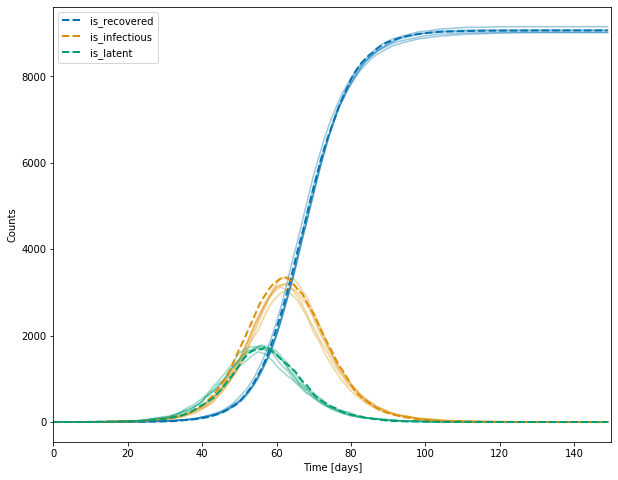

In [57]:
plt.figure(figsize=(10, 8))
colors = sns.color_palette("colorblind", 3)
df, w = h_loaded.get_distribution(m=0)
for i in range(5):
    pars = df.sample(1, weights=w).to_dict(orient="list")
    pars = {key: val[0] for key, val in pars.items()}
   
    #pars["recovery dur mean"] = 0.01
    sim_data, _ = model(pars, "minimal")
    for field, col in zip(fields, colors):
        plt.plot(sim_data[field], color=col, alpha=0.4)
for field, col in zip(fields, colors):
    plt.plot(data[field], color=col, ls="--", label=field, lw=2)
    
"""
mean_sim, _ = model(par_modes)
for field, col in zip(fields, colors):
    plt.plot(mean_sim[field], color=col, ls="-", label=field, lw=3)
""" 

    
plt.xlabel("Time [days]")
plt.ylabel("Counts")
plt.legend()
plt.xlim(0, 150)
#plt.semilogy()

In [11]:
sorted_pop = h_loaded.get_population_extended().sort_values("distance")

In [12]:
bfs = [{par_name[4:]: sorted_pop.iloc[i][par_name] for par_name in sorted_pop.iloc[i].index if "par" in par_name} for i in range(10)]

{'incub dur mean': 6.2374426064231825, 'incub dur sd': 12.633753656541975, 'inf prob max': 0.3107145862754293, 'infectious dur mean': 8.925685426168336, 'latency mean': 4.074294688970392, 'recovery dur mean': 0.31518722505236946, 'soc circ mean': 5.391668454160342}
{'incub dur mean': 14.395885245954961, 'incub dur sd': 10.441771041978186, 'inf prob max': 0.23885024482160358, 'infectious dur mean': 7.25163309195745, 'latency mean': 4.065532327997975, 'recovery dur mean': 1.5574738121321572, 'soc circ mean': 5.223424147163309}


(0, 150)

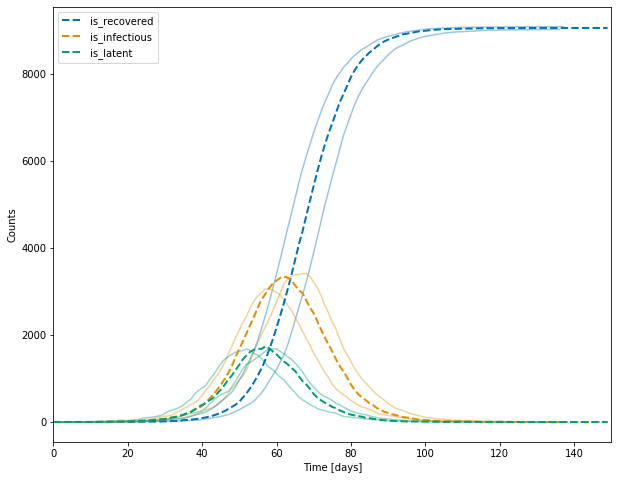

In [13]:
plt.figure(figsize=(10, 8))
colors = sns.color_palette("colorblind", 3)
min_dists = h_loaded.get_weighted_distances().sort_values("distance").index[:10]
df, w = h_loaded.get_distribution(m=0)
for i in range(2):
    #pars = df.iloc[min_dists[i]].to_dict()
    #pars = {key: val for key, val in pars.items()}
    pars = bfs[i]
    print(pars)
   
    #pars["recovery dur mean"] = 0.01
    sim_data, _ = model(pars, "minimal")
    for field, col in zip(fields, colors):
        plt.plot(sim_data[field], color=col, alpha=0.4)
for field, col in zip(fields, colors):
    plt.plot(data[field], color=col, ls="--", label=field, lw=2)
    
"""
mean_sim, _ = model(par_modes)
for field, col in zip(fields, colors):
    plt.plot(mean_sim[field], color=col, ls="-", label=field, lw=3)
""" 

    
plt.xlabel("Time [days]")
plt.ylabel("Counts")
plt.legend()
plt.xlim(0, 150)
#plt.semilogy()

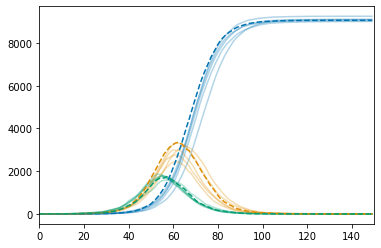

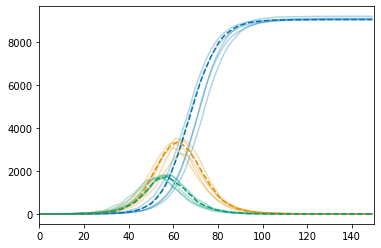

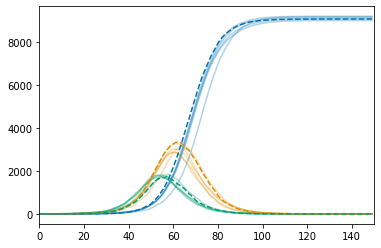

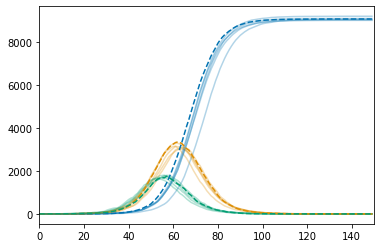

In [30]:
colors = sns.color_palette("colorblind", 3)
for step in range(max(h_loaded.max_t-3, 0), h_loaded.max_t+1):
    df, w = h_loaded.get_distribution(m=0, t=step)
    plt.figure()  
    for i in range(5):
        pars = df.sample(1, weights=w).to_dict(orient="list")
        pars = {key: val[0] for key, val in pars.items()}
        #pars["recovery dur mean"] = 0.01
        sim_data, _ = model(pars, "minimal")
        for field, col in zip(fields, colors):
            plt.plot(sim_data[field], color=col, alpha=0.3)
    for field, col in zip(fields, colors):
        plt.plot(data[field], color=col, ls="--")
        
    
    #par_means = {col: np.average(df[col].values, weights=w ).item() for col in df.columns}
    #par_means = {col: weighted_quantile(df[col].values, [0.5], sample_weight=w ).item() for col in df.columns}
    
    # plt.plot(sim_data["is_quarantined"], color="k", ls="-")
    plt.xlim(0, 150)
    

In [22]:

for index in min_dists:
    print(df.iloc[index].to_dict())
    

{'incub dur mean': 2.737370669627129, 'inf prob max': 0.32734761993874756, 'infectious dur mean': 8.083432306043921, 'latency mean': 4.076925550609567, 'recovery dur mean': 1.9784900019430545, 'soc circ mean': 5.835203520366172}
{'incub dur mean': 9.22618869683867, 'inf prob max': 0.2160606880692971, 'infectious dur mean': 8.12547979385494, 'latency mean': 4.681050510720598, 'recovery dur mean': 2.7492213081321415, 'soc circ mean': 6.078437031962333}
{'incub dur mean': 14.638254587815801, 'inf prob max': 0.20231189473792013, 'infectious dur mean': 7.864953867692829, 'latency mean': 4.615335322730579, 'recovery dur mean': 3.8468287452071817, 'soc circ mean': 5.979216200216107}
{'incub dur mean': 8.628048240929004, 'inf prob max': 0.21177621722113835, 'infectious dur mean': 8.58913556497949, 'latency mean': 4.201072668194421, 'recovery dur mean': 3.813534714286254, 'soc circ mean': 6.299442179083337}
{'incub dur mean': 5.98676625100423, 'inf prob max': 0.24342014342878318, 'infectious du

(0, 150)

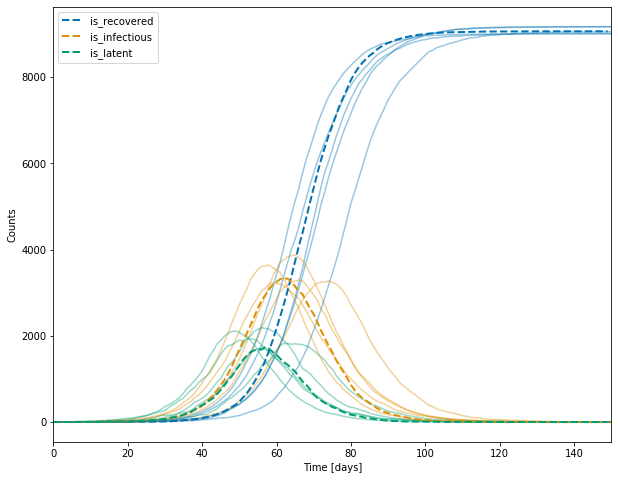

In [58]:
plt.figure(figsize=(10, 8))
colors = sns.color_palette("colorblind", 3)
df, w = h_loaded.get_distribution(m=0)
for i in range(5):
    pars = df.sample(1, weights=w).to_dict(orient="list")
    pars = {key: val[0] for key, val in pars.items()}
   
    #pars["recovery dur mean"] = 0.01
    sim_data, _ = model(pars)
    for field, col in zip(fields, colors):
        plt.plot(sim_data[field], color=col, alpha=0.4)
for field, col in zip(fields, colors):
    plt.plot(data[field], color=col, ls="--", label=field, lw=2)
    
"""
mean_sim, _ = model(par_modes)
for field, col in zip(fields, colors):
    plt.plot(mean_sim[field], color=col, ls="-", label=field, lw=3)
""" 

    
plt.xlabel("Time [days]")
plt.ylabel("Counts")
plt.legend()
plt.xlim(0, 150)
#plt.semilogy()

In [ ]:
{'incub dur mean': 2.3290047733978576, 'inf prob max': 0.19757213625222564, 'infectious dur mean': 9.484732622317368, 'latency mean': 5.208422423115933, 'recovery dur mean': 2.8480925993039503, 'soc circ mean': 6.3164203780607195}

In [ ]:
plt.figure(figsize=(10, 8))
colors = sns.color_palette("colorblind", 3)
df, w = h_loaded.get_distribution(m=0)
for i in range(5):
    pars = df.sample(1, weights=w).to_dict(orient="list")
    pars = {key: val[0] for key, val in pars.items()}
    pars[""]
   
    #pars["recovery dur mean"] = 0.01
    sim_data, _ = model(pars)
    for field, col in zip(fields, colors):
        plt.plot(sim_data[field], color=col, alpha=0.4)
for field, col in zip(fields, colors):
    plt.plot(data[field], color=col, ls="--", label=field, lw=2)
    
"""
mean_sim, _ = model(par_modes)
for field, col in zip(fields, colors):
    plt.plot(mean_sim[field], color=col, ls="-", label=field, lw=3)
""" 

    
plt.xlabel("Time [days]")
plt.ylabel("Counts")
plt.legend()
plt.xlim(0, 150)
#plt.semilogy()

(0.0, 150.0)

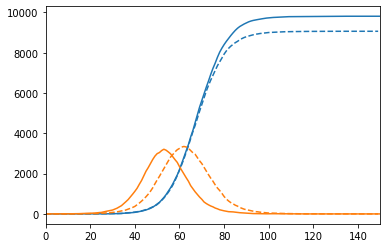

In [19]:

for field in fields:
    lines = plt.plot(sim_data[field])
    col = lines[0].get_color()
    plt.plot(data[field], color=col, ls="--")
plt.xlim(0, 150)

In [21]:
import scipy.stats

incub dur mean [2.3290296]
inf prob max [0.19757214]
infectious dur mean [9.48472497]
latency mean [5.20842475]
recovery dur mean [2.84822352]
soc circ mean [6.31650976]
